In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive

Mounted at /content/drive
/content/drive/MyDrive


In [ ]:
!pip install lime

In [ ]:
!pip install optuna

In [ ]:
!pip install transformers torch

In [ ]:
!pip install pysal

In [ ]:
!pip install shap

In [ ]:
# General libraries
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning and modeling libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.linear_model import LinearRegression
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans, DBSCAN

# Geospatial analysis libraries
import folium
from folium.plugins import HeatMap
from geopy.distance import geodesic

# GeoPandas and PySAL for spatial autocorrelation (Moran's I and LISA)
import geopandas as gpd
from pysal.lib import weights
from pysal.explore import esda

# Sentiment analysis
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Missing value handling and feature engineering
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PolynomialFeatures

# Hyperparameter tuning
import optuna
from optuna.trial import Trial
from sklearn.model_selection import cross_val_score

# LightGBM
import lightgbm as lgb
import lime
import lime.lime_tabular
import sklearn.ensemble

#shap
import shap


In [ ]:
# Load data
data = pd.read_csv('/content/drive/MyDrive/KDAG Hackathon/Homestays_Data.csv')

# Convert date columns
data['host_since'] = pd.to_datetime(data['host_since'], errors='coerce')
data['last_review'] = pd.to_datetime(data['last_review'], errors='coerce')

# Drop rows with missing 'host_since' or 'last_review' as they are critical for feature engineering
data = data.dropna(subset=['host_since', 'last_review'])

# Feature Engineering using .loc[]
data.loc[:, 'Host_Tenure'] = (datetime.now() - data['host_since']).dt.days / 365
data.loc[:, 'Amenities_Count'] = data['amenities'].apply(lambda x: len(x.split(',')) if isinstance(x, str) else 0)
data.loc[:, 'Days_Since_Last_Review'] = (datetime.now() - data['last_review']).dt.days

# Fill missing values in newly created features with 0 where appropriate
data.loc[:, 'Host_Tenure'].fillna(0, inplace=True)
data.loc[:, 'Days_Since_Last_Review'].fillna(0, inplace=True)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

for column in data.columns:
  print(f"Column '{column}' has {data[column].nunique()} unique values.")


In [ ]:
# Drop columns that won't be used
data = data.drop(columns=['id', 'name', 'thumbnail_url'])

# Handle categorical data
label_encoder = LabelEncoder()
data['property_type_encoded'] = label_encoder.fit_transform(data['property_type'])
data['room_type_encoded'] = label_encoder.fit_transform(data['room_type'])
data['bed_type_encoded'] = label_encoder.fit_transform(data['bed_type'])
data['cancellation_policy_encoded'] = label_encoder.fit_transform(data['cancellation_policy'])
data['city_encoded'] = label_encoder.fit_transform(data['city'])
data['neighbourhood_encoded'] = label_encoder.fit_transform(data['neighbourhood'])
data['zipcode_encoded'] = label_encoder.fit_transform(data['zipcode'])


In [ ]:
data['amenities'][2]

'{TV,"Cable TV","Wireless Internet","Air conditioning",Kitchen,Breakfast,"Buzzer/wireless intercom",Heating,"Family/kid friendly","Smoke detector","Carbon monoxide detector","Fire extinguisher",Essentials,Shampoo,Hangers,"Hair dryer",Iron,"Laptop friendly workspace","translation missing: en.hosting_amenity_50"}'

In [ ]:
import re

# Function to manually clean the amenities strings and convert them to a list
def clean_amenities(amenities):
    if isinstance(amenities, str):  # Check if the data is a string
        # Remove the curly braces
        amenities = amenities.strip('{}')

        # Replace double quotes with nothing to normalize unquoted items
        amenities = amenities.replace('"', '')

        # Split the string by commas to create a list of amenities
        return re.split(r',\s*(?![^()]*\))', amenities)  # Split, ignoring commas within parentheses (if any)
    return amenities

# Apply the cleaning function
data['Amenities_List'] = data['amenities'].apply(clean_amenities)

# Check if the column is now properly converted to lists
print(data['Amenities_List'].head())

0    [Internet, Wireless Internet, Air conditioning...
1    [TV, Internet, Wireless Internet, Air conditio...
2    [TV, Wireless Internet, Air conditioning, Kitc...
3    [TV, Wireless Internet, Kitchen, Family/kid fr...
4    [Wireless Internet, Air conditioning, Kitchen,...
Name: Amenities_List, dtype: object


In [ ]:
# Create binary columns for top amenities
top_amenities = data['Amenities_List'].explode().value_counts().head(20).index.tolist()
for amenity in top_amenities:
    data[f'amenity_{amenity}'] = data['Amenities_List'].apply(lambda x: 1 if amenity in x else 0)

In [ ]:
data.columns

Index(['log_price', 'property_type', 'room_type', 'amenities', 'accommodates',
       'bathrooms', 'bed_type', 'cancellation_policy', 'cleaning_fee', 'city',
       'description', 'first_review', 'host_has_profile_pic',
       'host_identity_verified', 'host_response_rate', 'host_since',
       'instant_bookable', 'last_review', 'latitude', 'longitude',
       'neighbourhood', 'number_of_reviews', 'review_scores_rating', 'zipcode',
       'bedrooms', 'beds', 'Host_Tenure', 'Amenities_Count',
       'Days_Since_Last_Review', 'property_type_encoded', 'room_type_encoded',
       'bed_type_encoded', 'cancellation_policy_encoded', 'city_encoded',
       'neighbourhood_encoded', 'zipcode_encoded', 'Amenities_List',
       'amenity_Wireless Internet', 'amenity_Heating', 'amenity_Kitchen',
       'amenity_Essentials', 'amenity_Smoke detector',
       'amenity_Air conditioning', 'amenity_TV', 'amenity_Shampoo',
       'amenity_Hangers', 'amenity_Carbon monoxide detector',
       'amenity_Intern

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader, Dataset

# Load DistilBERT (SST-2) for binary sentiment analysis
distilbert_tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased-finetuned-sst-2-english')
distilbert_model = AutoModelForSequenceClassification.from_pretrained('distilbert-base-uncased-finetuned-sst-2-english')

# Load RoBERTa for multi-class sentiment analysis
roberta_tokenizer = AutoTokenizer.from_pretrained('cardiffnlp/twitter-roberta-base-sentiment')
roberta_model = AutoModelForSequenceClassification.from_pretrained('cardiffnlp/twitter-roberta-base-sentiment')

# Custom dataset class for batching
class SentimentDataset(Dataset):
    def __init__(self, texts):
        self.texts = texts

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return self.texts[idx]

# Function to get sentiment scores using DistilBERT (SST-2) in batches
def get_distilbert_sentiment_scores_in_batches(texts, batch_size=32):
    dataset = SentimentDataset(texts)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    sentiment_scores = []
    distilbert_model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    distilbert_model.to(device)

    for batch in dataloader:
        inputs = distilbert_tokenizer(batch, return_tensors='pt', truncation=True, padding=True, max_length=512).to(device)
        with torch.no_grad():
            outputs = distilbert_model(**inputs)
        probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
        for prob in probs:
            sentiment_scores.append({
                "positive": prob[1].item(),
                "negative": prob[0].item(),
                "neutral": 1 - max(prob[0].item(), prob[1].item())  # Approximate neutral score
            })
    return sentiment_scores

# Function to get sentiment scores using RoBERTa (multi-class sentiment: positive, neutral, negative) in batches
def get_roberta_sentiment_scores_in_batches(texts, batch_size=32):
    dataset = SentimentDataset(texts)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    sentiment_scores = []
    roberta_model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    roberta_model.to(device)

    for batch in dataloader:
        inputs = roberta_tokenizer(batch, return_tensors='pt', truncation=True, padding=True, max_length=512).to(device)
        with torch.no_grad():
            outputs = roberta_model(**inputs)
        probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
        for prob in probs:
            sentiment_scores.append({
                "positive": prob[2].item(),
                "neutral": prob[1].item(),
                "negative": prob[0].item()
            })
    return sentiment_scores

# Function to apply both models and average the scores in batches
def get_combined_sentiment_scores_in_batches(distilbert_scores, roberta_scores, batch_size=32):
  combined_scores = []
  for distilbert, roberta in zip(distilbert_scores, roberta_scores):
      positive_score = np.mean([distilbert['positive'], roberta['positive']])
      negative_score = np.mean([distilbert['negative'], roberta['negative']])
      neutral_score = np.mean([distilbert['neutral'], roberta['neutral']])
      combined_scores.append({
          "positive": positive_score,
          "negative": negative_score,
          "neutral": neutral_score
      })
  return combined_scores

In [ ]:
batch_size = 32  # Adjust batch size based on available memory
distilbert_scores = get_distilbert_sentiment_scores_in_batches(data['description'].tolist(), batch_size=batch_size)

In [ ]:
roberta_scores = get_roberta_sentiment_scores_in_batches(data['description'].tolist(), batch_size=batch_size)

                                         description  Positive_Score  \
0  Beautiful, sunlit brownstone 1-bedroom in the ...        0.988407   
1  Enjoy travelling during your stay in Manhattan...        0.964483   
2  The Oasis comes complete with a full backyard ...        0.923385   
4  Cool, cozy, and comfortable studio located in ...        0.956585   
5  Beautiful private room overlooking scenic view...        0.970775   

   Negative_Score  Neutral_Score  
0        0.000656       0.011004  
1        0.001174       0.034777  
2        0.006341       0.071575  
4        0.001634       0.042277  
5        0.001362       0.027969  


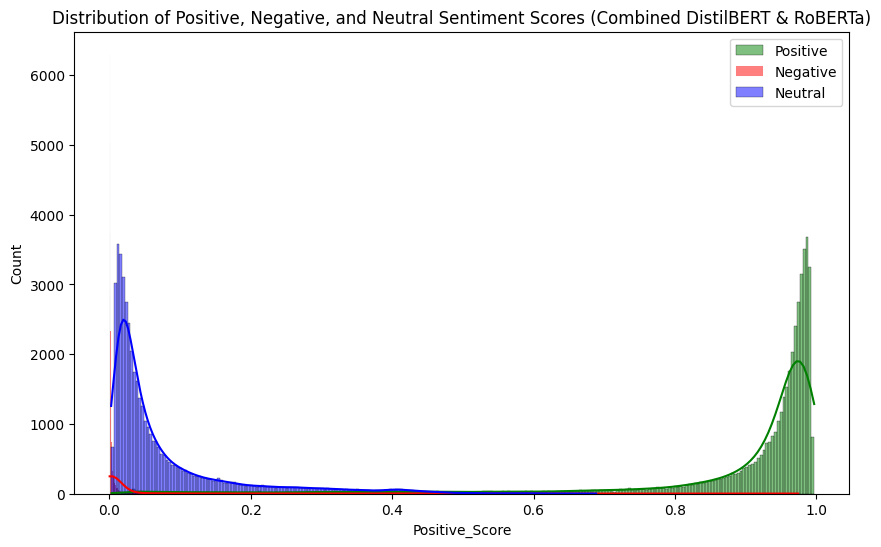

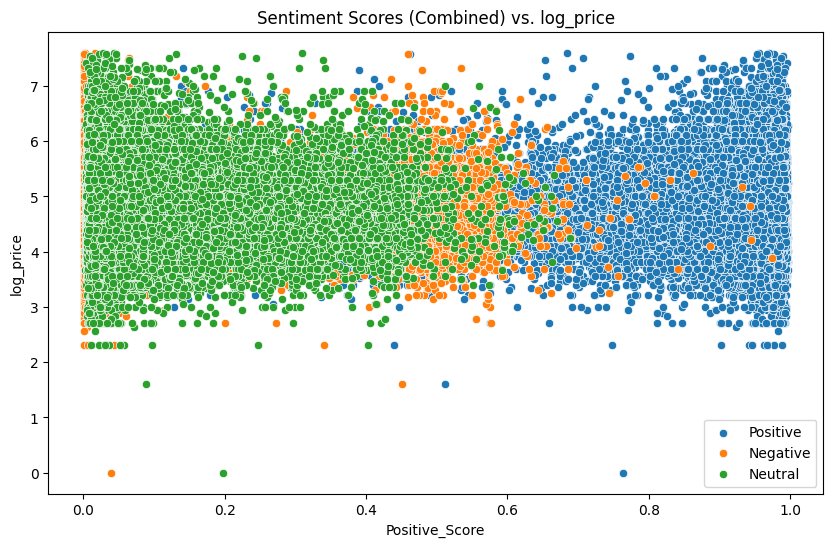

In [ ]:

combined_sentiment_scores = get_combined_sentiment_scores_in_batches(distilbert_scores, roberta_scores, batch_size=batch_size)

# Create new columns for Positive, Negative, and Neutral scores in the DataFrame
sentiment_df = pd.DataFrame(combined_sentiment_scores)
data[['Positive_Score', 'Negative_Score', 'Neutral_Score']] = sentiment_df

# Display the sentiment scores
print(data[['description', 'Positive_Score', 'Negative_Score', 'Neutral_Score']].head())

# Plot Distribution of Positive, Negative, and Neutral Scores
plt.figure(figsize=(10, 6))
sns.histplot(data['Positive_Score'], kde=True, color='green', label='Positive')
sns.histplot(data['Negative_Score'], kde=True, color='red', label='Negative')
sns.histplot(data['Neutral_Score'], kde=True, color='blue', label='Neutral')
plt.title('Distribution of Positive, Negative, and Neutral Sentiment Scores (Combined DistilBERT & RoBERTa)')
plt.legend()
plt.show()

# Correlation with log_price
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Positive_Score', y='log_price', data=data, label='Positive')
sns.scatterplot(x='Negative_Score', y='log_price', data=data, label='Negative')
sns.scatterplot(x='Neutral_Score', y='log_price', data=data, label='Neutral')
plt.title('Sentiment Scores (Combined) vs. log_price')
plt.legend()
plt.show()

In [ ]:
data.to_csv('/content/drive/MyDrive/KDAG Hackathon/Homestays_Data_Sentiment.csv', index=False)

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/KDAG Hackathon/Homestays_Data_Sentiment.csv')

<ipython-input-10-423c5885cca1>:1: DtypeWarning: Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('/content/drive/MyDrive/KDAG Hackathon/Homestays_Data_Sentiment.csv')


In [ ]:
#  Proximity Gradient Analysis

# Function to calculate city and neighborhood centers and proximity features
def calculate_proximity(city_data):
    # Calculate city center
    city_center_coords = (city_data['latitude'].mean(), city_data['longitude'].mean())
    city_data['distance_to_city_center'] = city_data.apply(
        lambda row: geodesic((row['latitude'], row['longitude']), city_center_coords).km, axis=1)

    return city_data

# Apply the proximity calculations for distance to city center
data = data.groupby('city_encoded', as_index=False).apply(calculate_proximity)

In [ ]:
city_name_mapping = {
    0: 'Boston',
    1: 'Chicago',
    2: 'DC',
    3: 'LA',
    4: 'NYC',
    5: 'SF'
}

# Function to retrieve city name from city_encoded value
def get_city_name(city_encoded):
    return city_name_mapping.get(city_encoded, "Unknown City")

In [ ]:
# Function to find the optimal number of clusters using both Silhouette Score and Elbow Method
def find_optimal_clusters(city_data, max_clusters=10):
    clustering_features = ['latitude', 'longitude', 'distance_to_city_center']

    # Standardize the data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(city_data[clustering_features])

    sse = []
    silhouette_scores = []

    for n_clusters in range(2, max_clusters + 1):
        # Perform Agglomerative Clustering
        clustering_model = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
        labels = clustering_model.fit_predict(scaled_data)

        # Sum of squared errors (SSE) for Elbow Method
        sse.append(np.sum(np.min(np.square(scaled_data - np.mean(scaled_data, axis=0)), axis=1)))

        # Silhouette Score
        silhouette_avg = silhouette_score(scaled_data, labels)
        silhouette_scores.append(silhouette_avg)

    # Elbow method: find where the rate of SSE reduction slows down
    optimal_clusters_elbow = np.argmax(np.diff(sse)) + 2  # Adding 2 because index starts from 0

    # Silhouette method: find the maximum silhouette score
    optimal_clusters_silhouette = np.argmax(silhouette_scores) + 2  # Adding 2 because we started from 2 clusters

    # Determine the optimal number of clusters using both methods
    if optimal_clusters_silhouette > optimal_clusters_elbow:
        optimal_n_clusters = optimal_clusters_silhouette
    else:
        optimal_n_clusters = optimal_clusters_elbow

    return optimal_n_clusters


#  Hierarchical Clustering with Optimal Clusters
def cluster_within_city(city_data):
    optimal_clusters = find_optimal_clusters(city_data)

    # Select features for clustering
    clustering_features = ['latitude', 'longitude', 'distance_to_city_center']
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(city_data[clustering_features])

    # Perform Agglomerative Clustering with optimal number of clusters
    clustering_model = AgglomerativeClustering(n_clusters=optimal_clusters, linkage='ward')
    city_data['spatial_price_cluster'] = clustering_model.fit_predict(scaled_data)

    return city_data

# Apply hierarchical clustering within each city
data = data.groupby('city_encoded', as_index=False).apply(cluster_within_city)

# Calculate Distance to Cluster Center
def calculate_cluster_centers(city_data):
    cluster_centers = city_data.groupby('spatial_price_cluster')[['latitude', 'longitude']].mean().reset_index()
    cluster_center_dict = dict(zip(cluster_centers['spatial_price_cluster'],
                                   zip(cluster_centers['latitude'], cluster_centers['longitude'])))

    # Calculate distance to cluster center
    city_data['distance_to_cluster_center'] = city_data.apply(
        lambda row: geodesic((row['latitude'], row['longitude']),
                             cluster_center_dict[row['spatial_price_cluster']]).km, axis=1)

    # Add cluster center coordinates for plotting
    city_data['cluster_center_latitude'] = city_data['spatial_price_cluster'].map(lambda x: cluster_center_dict[x][0])
    city_data['cluster_center_longitude'] = city_data['spatial_price_cluster'].map(lambda x: cluster_center_dict[x][1])

    return city_data

# Apply the cluster center proximity calculation
data = data.groupby('city_encoded', as_index=False).apply(calculate_cluster_centers)

# Plot Spatial Clusters with City and Cluster Centers


In [ ]:
def plot_clusters_with_centers(city_encoded):
    city_data = data[data['city_encoded'] == city_encoded]
    city_name = get_city_name(city_encoded)

    plt.figure(figsize=(10, 6))

    # Scatter plot of listings colored by cluster
    sns.scatterplot(x='longitude', y='latitude', hue='spatial_price_cluster', data=city_data, palette='viridis', alpha=0.6)

    # Plot city center
    city_center = [city_data['longitude'].mean(), city_data['latitude'].mean()]
    plt.scatter(city_center[0], city_center[1], color='red', s=200, label='City Center', marker='x')

    # Plot cluster centers
    cluster_centers = city_data[['cluster_center_longitude', 'cluster_center_latitude']].drop_duplicates()
    plt.scatter(cluster_centers['cluster_center_longitude'], cluster_centers['cluster_center_latitude'],
                color='orange', s=150, label='Cluster Centers', marker='o')

    plt.title(f"Spatial Price Clusters with Centers in {city_name}")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.legend()
    plt.show()

# Plot for a specific city
plot_clusters_with_centers(0)
plot_clusters_with_centers(1)
plot_clusters_with_centers(2)
plot_clusters_with_centers(3)
plot_clusters_with_centers(4)
plot_clusters_with_centers(5)


#  Plot Price vs Distance to City and Cluster Centers
def plot_price_vs_distance(city_encoded):
    city_data = data[data['city_encoded'] == city_encoded]
    city_name = get_city_name(city_encoded)

    plt.figure(figsize=(10, 6))

    # Scatter plot for distance to city center and log price
    sns.scatterplot(x='distance_to_city_center', y='log_price', data=city_data, color='blue', label='Distance to City Center', alpha=0.6)

    # Scatter plot for distance to cluster center and log price
    sns.scatterplot(x='distance_to_cluster_center', y='log_price', data=city_data, color='green', label='Distance to Cluster Center', alpha=0.6)

    # Polynomial regression to show trends
    poly = PolynomialFeatures(degree=2)
    X_poly_city = poly.fit_transform(city_data[['distance_to_city_center']])
    X_poly_cluster = poly.fit_transform(city_data[['distance_to_cluster_center']])

    poly_reg = LinearRegression()
    poly_reg.fit(X_poly_city, city_data['log_price'])

    # Generate values for polynomial regression lines
    x_vals_city = np.linspace(city_data['distance_to_city_center'].min(), city_data['distance_to_city_center'].max(), 100).reshape(-1, 1)
    y_vals_city = poly_reg.predict(poly.transform(x_vals_city))

    # Plot polynomial regression line for city center
    plt.plot(x_vals_city, y_vals_city, color='red', label='Trend: City Center')

    # Polynomial regression for cluster center
    poly_reg.fit(X_poly_cluster, city_data['log_price'])
    x_vals_cluster = np.linspace(city_data['distance_to_cluster_center'].min(), city_data['distance_to_cluster_center'].max(), 100).reshape(-1, 1)
    y_vals_cluster = poly_reg.predict(poly.transform(x_vals_cluster))

    # Plot polynomial regression line for cluster center
    plt.plot(x_vals_cluster, y_vals_cluster, color='orange', label='Trend: Cluster Center')

    plt.title(f'Log Price vs Distance to Centers in {city_name}')
    plt.xlabel('Distance (km)')
    plt.ylabel('Log Price')
    plt.legend()
    plt.show()

plot_price_vs_distance(0)
plot_price_vs_distance(1)
plot_price_vs_distance(2)
plot_price_vs_distance(3)
plot_price_vs_distance(4)
plot_price_vs_distance(5)

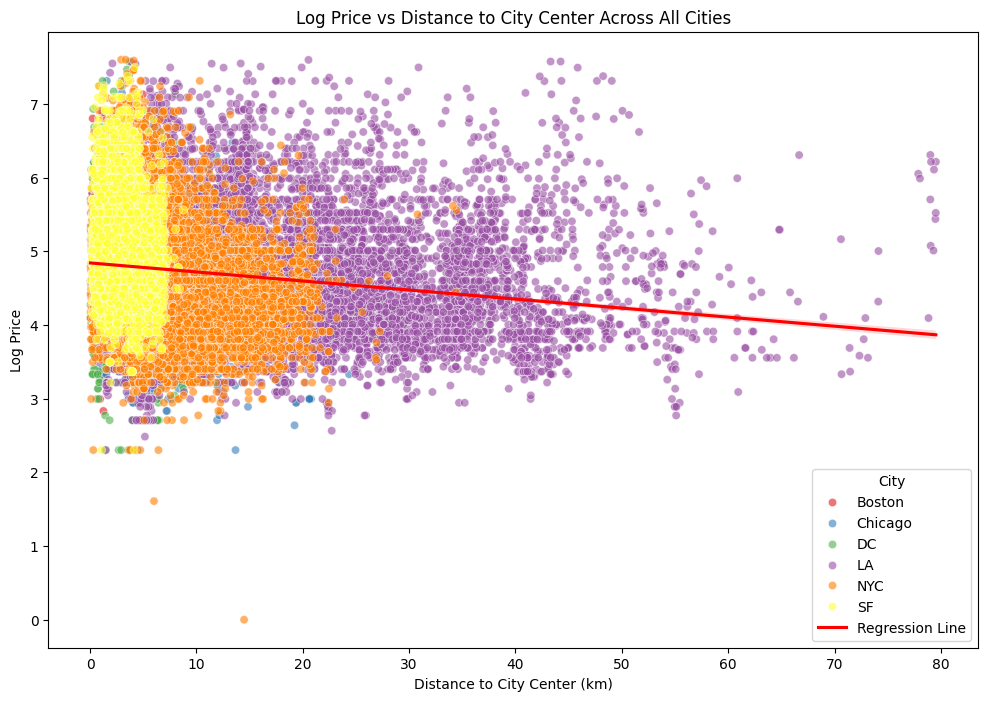

In [ ]:
def plot_combined_price_vs_distance():
    # Create a new column with city names based on city_encoded
    city_name_mapping = dict(zip(data['city_encoded'], data['city']))
    data['city_name'] = data['city_encoded'].map(city_name_mapping)

    plt.figure(figsize=(12, 8))

    # Scatter plot for distance to city center and log price, with differentiated city colors
    sns.scatterplot(x='distance_to_city_center', y='log_price', hue='city_name', data=data, palette='Set1', alpha=0.6)

    # Add a regression line for all data
    sns.regplot(x='distance_to_city_center', y='log_price', data=data, scatter=False, color='red', label='Regression Line')

    # Title and axis labels
    plt.title('Log Price vs Distance to City Center Across All Cities')
    plt.xlabel('Distance to City Center (km)')
    plt.ylabel('Log Price')
    plt.legend(title='City')
    plt.show()

# Call the function to plot the combined price vs distance graph
plot_combined_price_vs_distance()


In [ ]:
#  Convert data to GeoDataFrame for Moran’s I and LISA analysis
gdf = gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(data.longitude, data.latitude))

# Create an integer index as the ID to avoid unhashable types
gdf['id'] = range(len(gdf))

# Generate spatial weights matrix using K-nearest neighbors
w = weights.KNN.from_dataframe(gdf, k=5, ids=gdf['id'])

# Calculate Moran’s I for global spatial autocorrelation of log_price
moran = esda.Moran(gdf['log_price'], w)
print(f"Moran’s I: {moran.I}, p-value: {moran.p_sim}")

# Local Indicators of Spatial Autocorrelation (LISA)
lisa = esda.Moran_Local(gdf['log_price'], w)
gdf['LISA_cluster'] = lisa.q  # Assign LISA cluster labels

# Map LISA clusters back to the original DataFrame (data)
data['LISA_cluster'] = gdf['LISA_cluster'].values

#  Define a function to plot LISA clusters for each city
def plot_lisa_by_city(city_encoded):
    # Filter data for the city
    city_data = gdf[gdf['city_encoded'] == city_encoded]
    city_name = city_data['city'].iloc[0]  # Get the city name

    # Generate spatial weights for the specific city
    w_city = weights.KNN.from_dataframe(city_data, k=5, ids=city_data['id'])

    # Perform LISA analysis for the city
    lisa_city = esda.Moran_Local(city_data['log_price'], w_city)

    # Add LISA cluster results to the GeoDataFrame
    city_data['LISA_cluster'] = lisa_city.q

    # Define a color palette with labels for LISA clusters
    lisa_colors = {
        1: 'red',        # High-High (Hotspot)
        2: 'blue',       # Low-High
        3: 'lightblue',  # Low-Low (Coldspot)
        4: 'orange',     # High-Low
    }

    # Create a scatter plot for the LISA clusters
    plt.figure(figsize=(10, 6))

    sns.scatterplot(data=city_data, x='longitude', y='latitude', hue='LISA_cluster', palette=lisa_colors, alpha=0.6)

    # Plot the city center
    city_center = [city_data['longitude'].mean(), city_data['latitude'].mean()]
    plt.scatter(city_center[0], city_center[1], color='black', s=200, label='City Center', marker='x')

    # Add titles and labels
    plt.title(f"LISA Clusters: Hotspots and Coldspots in {city_name}")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")

    # Update the legend to show what each color represents
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', label='High-High (Hotspot)', markerfacecolor='red', markersize=10),
        Line2D([0], [0], marker='o', color='w', label='Low-High', markerfacecolor='blue', markersize=10),
        Line2D([0], [0], marker='o', color='w', label='Low-Low (Coldspot)', markerfacecolor='lightblue', markersize=10),
        Line2D([0], [0], marker='o', color='w', label='High-Low', markerfacecolor='orange', markersize=10),
        Line2D([0], [0], marker='x', color='black', label='City Center', markersize=10)
    ]

    plt.legend(handles=legend_elements, title="LISA Clusters")
    plt.show()

# Loop through each city and plot LISA clusters with city names
for city_encoded in gdf['city_encoded'].unique():
    plot_lisa_by_city(city_encoded)

In [ ]:
from sklearn.neighbors import BallTree
import numpy as np

# Function to calculate the density of listings within a radius for each listing using BallTree
def calculate_listing_density_optimized(city_data, radius=1):
    # Convert latitude and longitude to radians
    coordinates = np.radians(city_data[['latitude', 'longitude']].values)

    # Build a BallTree for fast lookup
    tree = BallTree(coordinates, metric='haversine')  # 'haversine' metric is useful for lat/lon distance

    # Query the BallTree for neighbors within the given radius (in km, so we divide by Earth's radius ~6371 km)
    radius_in_radians = radius / 6371  # Convert km to radians
    density = tree.query_radius(coordinates, r=radius_in_radians, count_only=True)

    # Assign density values (subtract 1 to exclude the point itself)
    city_data['listing_density'] = density - 1  # Subtract 1 to not count the point itself

    return city_data

# Apply the listing density calculation for each city using the optimized function
def calculate_density_per_city_optimized(data, radius=1):
    data = data.groupby('city', as_index=False).apply(calculate_listing_density_optimized, radius=radius)
    return data

# Calculate listing density for the dataset using optimized method
data = calculate_density_per_city_optimized(data, radius=1)

# Function to plot listing density for each city
def plot_listing_density_per_city_optimized(data):
    cities = data['city'].unique()

    # Loop through each city and plot the listing density
    for city in cities:
        city_data = data[data['city'] == city]

        plt.figure(figsize=(10, 6))

        # Scatter plot with latitude and longitude, color-coded by listing density
        scatter = sns.scatterplot(
            x='longitude', y='latitude', hue='listing_density', palette='coolwarm',
            data=city_data, alpha=0.6, edgecolor=None)

        # Add a color bar for density
        plt.colorbar(scatter.collections[0], label="Listing Density")
        plt.title(f"Listing Density in {city}")
        plt.xlabel("Longitude")
        plt.ylabel("Latitude")
        plt.show()

# Plot the listing density for each city
plot_listing_density_per_city_optimized(data)

In [ ]:
data.columns

Index(['log_price', 'property_type', 'room_type', 'amenities', 'accommodates',
       'bathrooms', 'bed_type', 'cancellation_policy', 'cleaning_fee', 'city',
       'description', 'first_review', 'host_has_profile_pic',
       'host_identity_verified', 'host_response_rate', 'host_since',
       'instant_bookable', 'last_review', 'latitude', 'longitude',
       'neighbourhood', 'number_of_reviews', 'review_scores_rating', 'zipcode',
       'bedrooms', 'beds', 'Host_Tenure', 'Amenities_Count',
       'Days_Since_Last_Review', 'property_type_encoded', 'room_type_encoded',
       'bed_type_encoded', 'cancellation_policy_encoded', 'city_encoded',
       'neighbourhood_encoded', 'zipcode_encoded', 'Amenities_List',
       'amenity_Wireless Internet', 'amenity_Heating', 'amenity_Kitchen',
       'amenity_Essentials', 'amenity_Smoke detector',
       'amenity_Air conditioning', 'amenity_TV', 'amenity_Shampoo',
       'amenity_Hangers', 'amenity_Carbon monoxide detector',
       'amenity_Intern

In [ ]:
# Avoid division by zero for very close points
data['distance_to_city_center'] = data['distance_to_city_center'].replace(0, 0.0001)
data['distance_to_cluster_center'] = data['distance_to_cluster_center'].replace(0, 0.0001)


#  Normalize or scale the new features (Optional, depending on model requirements)
scaler = StandardScaler()
data[['distance_to_city_center', 'distance_to_cluster_center']] = scaler.fit_transform(
    data[['distance_to_city_center', 'distance_to_cluster_center']]
)

In [ ]:
correlation_features = ['distance_to_city_center', 'distance_to_cluster_center','listing_density', 'log_price']

# Calculate the Pearson correlation matrix
correlation_matrix = data[correlation_features].corr()

# Display only the correlation scores between the new features and log_price
correlation_with_log_price = correlation_matrix['log_price'].drop('log_price')

# Print the correlation scores
print("Correlation between new features and log_price:")
print(correlation_with_log_price)


Correlation between new features and log_price:
distance_to_city_center      -0.143335
distance_to_cluster_center   -0.080819
listing_density               0.159375
Name: log_price, dtype: float64


In [ ]:
data.columns

Index(['log_price', 'property_type', 'room_type', 'amenities', 'accommodates',
       'bathrooms', 'bed_type', 'cancellation_policy', 'cleaning_fee', 'city',
       'description', 'first_review', 'host_has_profile_pic',
       'host_identity_verified', 'host_response_rate', 'host_since',
       'instant_bookable', 'last_review', 'latitude', 'longitude',
       'neighbourhood', 'number_of_reviews', 'review_scores_rating', 'zipcode',
       'bedrooms', 'beds', 'Host_Tenure', 'Amenities_Count',
       'Days_Since_Last_Review', 'property_type_encoded', 'room_type_encoded',
       'bed_type_encoded', 'cancellation_policy_encoded', 'city_encoded',
       'neighbourhood_encoded', 'zipcode_encoded', 'Amenities_List',
       'amenity_Wireless Internet', 'amenity_Heating', 'amenity_Kitchen',
       'amenity_Essentials', 'amenity_Smoke detector',
       'amenity_Air conditioning', 'amenity_TV', 'amenity_Shampoo',
       'amenity_Hangers', 'amenity_Carbon monoxide detector',
       'amenity_Intern

In [ ]:
# Feature list for model
features = ['accommodates', 'bathrooms', 'number_of_reviews', 'review_scores_rating',
            'latitude', 'longitude', 'Host_Tenure', 'Amenities_Count', 'Days_Since_Last_Review',
            'property_type_encoded', 'room_type_encoded', 'bed_type_encoded',
            'cancellation_policy_encoded', 'city_encoded', 'neighbourhood_encoded',
            'zipcode_encoded','Positive_Score',
       'Negative_Score', 'Neutral_Score','distance_to_city_center', 'distance_to_cluster_center','listing_density'] + \
           [f'amenity_{amenity}' for amenity in top_amenities]

X = data[features]
y = data['log_price']


In [ ]:
X.head()

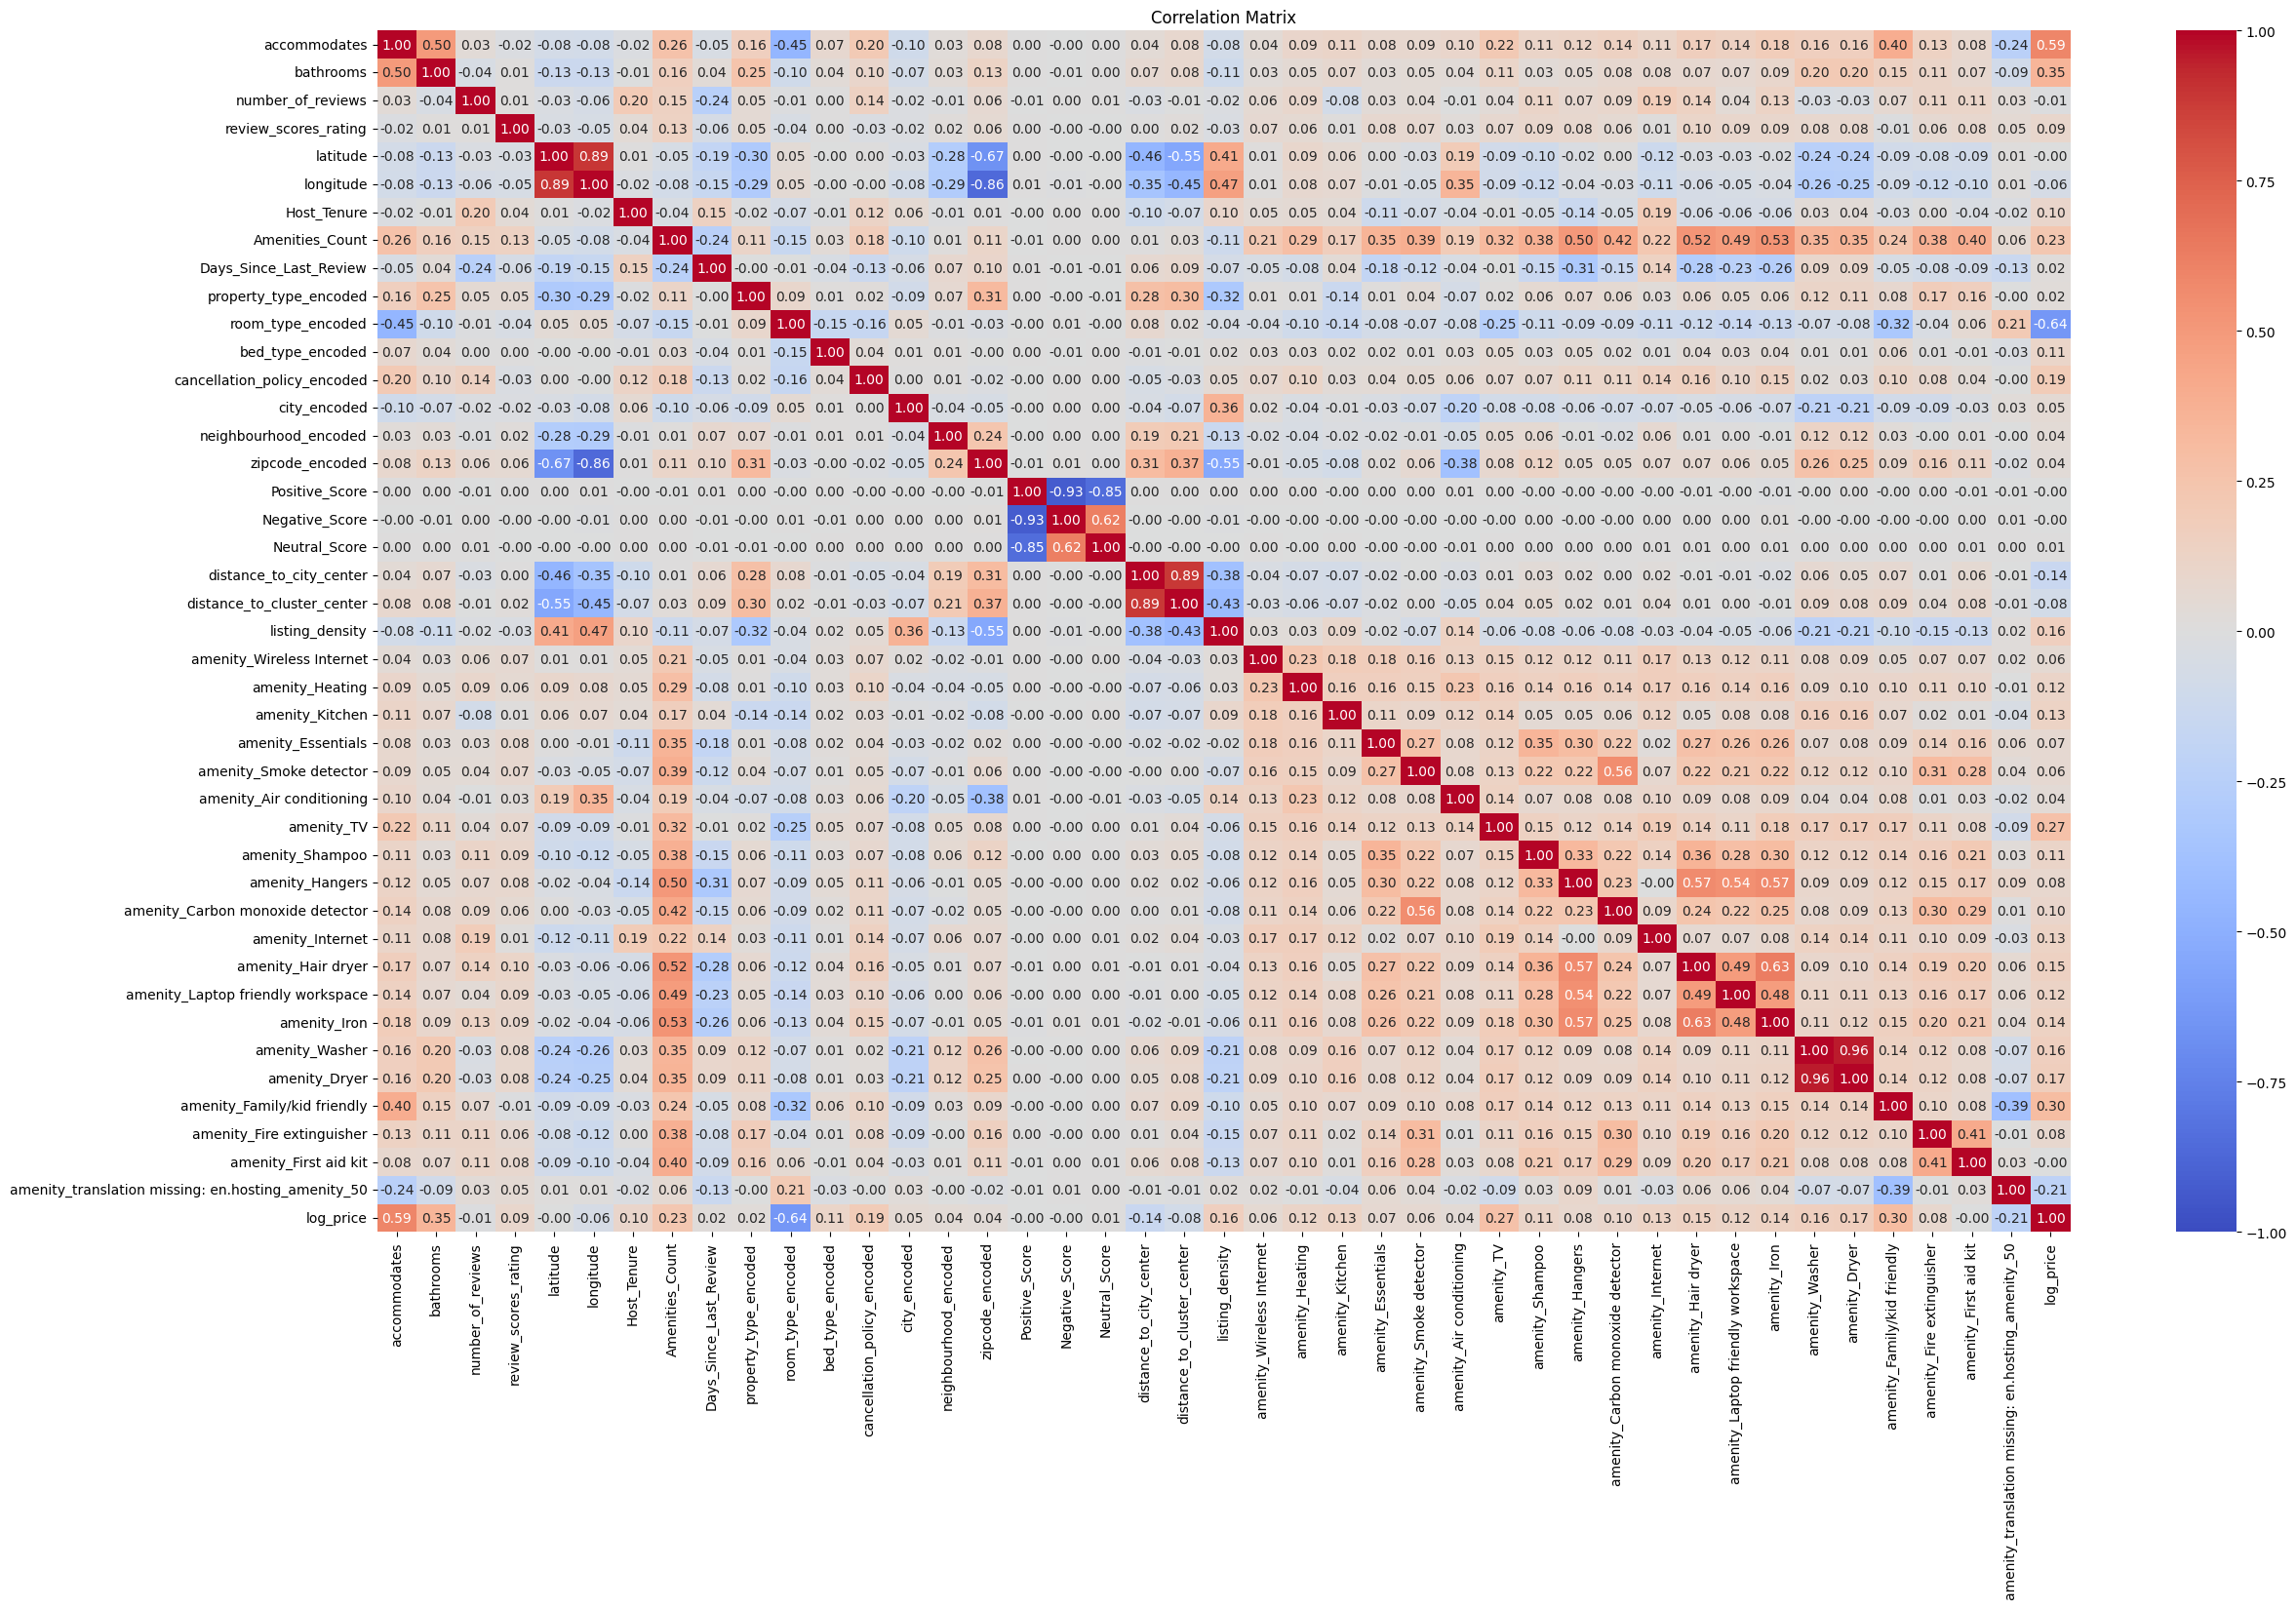

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the correlation matrix
corr_matrix = data[features + ['log_price']].corr()

# Plot the heatmap
plt.figure(figsize=(28, 16))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Matrix")
plt.show()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the correlation matrix
corr_matrix = data[features + ['log_price']].corr()

# Plot the heatmap
plt.figure(figsize=(28, 16))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Matrix")
plt.show()

In [ ]:
 #Scatter plots for some important numerical features against log_price
numerical_features = ['accommodates', 'bathrooms', 'number_of_reviews', 'review_scores_rating',
                      'latitude', 'longitude', 'Host_Tenure', 'Amenities_Count' ]

for feature in numerical_features:
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=data[feature], y=data['log_price'])
    plt.title(f'Scatter Plot: {feature} vs Log Price')
    plt.xlabel(feature)
    plt.ylabel('Log Price')
    plt.show()


In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import pandas as pd

# Assume X is your DataFrame with missing values

# Initialize the IterativeImputer (MICE)
imputer = IterativeImputer()

# Fit and transform the data
X_imputed = imputer.fit_transform(X)

# Convert the result back to a DataFrame with the original columns
X = pd.DataFrame(X_imputed, columns=X.columns)


In [ ]:

# Initialize Yeo-Johnson transformer
yeo_johnson_transformer = PowerTransformer(method='yeo-johnson')

# Apply Yeo-Johnson transformation on numerical features
transformed_data = yeo_johnson_transformer.fit_transform(X)

# Convert back to a DataFrame for easier visualization
transformed_df = pd.DataFrame(transformed_data, columns=X.columns)

# Scaling (standardization) after transformation
scaler = StandardScaler()
scaled_transformed_data = scaler.fit_transform(transformed_df)

# Convert scaled data back to a DataFrame
scaled_transformed_df = pd.DataFrame(scaled_transformed_data, columns=X.columns)


In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import pandas as pd
from geopy.distance import geodesic

# Drop rows with missing values in key geospatial columns
data = data.dropna(subset=['latitude', 'longitude', 'log_price'])

# Define a function to perform clustering within each city and neighborhood
def cluster_by_neighborhood(city_data):
    # Group further by neighborhood within each city
    for neighborhood in city_data['neighbourhood_encoded'].unique():
        neighborhood_data = city_data[city_data['neighbourhood_encoded'] == neighborhood]

        # Standardize latitudes and longitudes
        scaler = StandardScaler()
        coords = neighborhood_data[['latitude', 'longitude']].values
        coords_scaled = scaler.fit_transform(coords)

        # Perform DBSCAN clustering within each neighborhood
        db = DBSCAN(eps=0.2, min_samples=10).fit(coords_scaled)

        # Add cluster labels to the neighborhood data
        city_data.loc[city_data['neighbourhood_encoded'] == neighborhood, 'geo_cluster'] = db.labels_

    return city_data

# Apply the clustering function to each city with `as_index=False`
clustered_data = data.groupby('city_encoded', as_index=False).apply(cluster_by_neighborhood)


In [ ]:
# Function to calculate the city center and the distance from the city center for each point
def calculate_city_center(city_data):
    # Find the center of the city (mean latitude and longitude)
    city_center_coords = (city_data['latitude'].mean(), city_data['longitude'].mean())

    # Calculate the distance of each listing to the city center
    city_data['distance_to_center'] = city_data.apply(lambda row: geodesic((row['latitude'], row['longitude']), city_center_coords).km, axis=1)

    return city_data

# Apply this function to calculate distance from city center for each city
clustered_data = clustered_data.groupby('city_encoded', as_index=False).apply(calculate_city_center)


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Scatter plot for a specific city
def plot_city_analysis(city_encoded):
    city_data = clustered_data[clustered_data['city_encoded'] == city_encoded]

    # Scatter plot: Log Price vs Distance to City Center
    plt.figure(figsize=(10,6))
    sns.scatterplot(data=city_data, x='distance_to_center', y='log_price', hue='geo_cluster', palette='coolwarm')
    plt.title(f'Log Price vs Distance to City Center (City {city_encoded})')
    plt.xlabel('Distance to City Center (km)')
    plt.ylabel('Log Price')
    plt.show()

# Example: Plot geospatial analysis for Cities
plot_city_analysis(0)
plot_city_analysis(1)
plot_city_analysis(2)
plot_city_analysis(3)
plot_city_analysis(4)
plot_city_analysis(5)



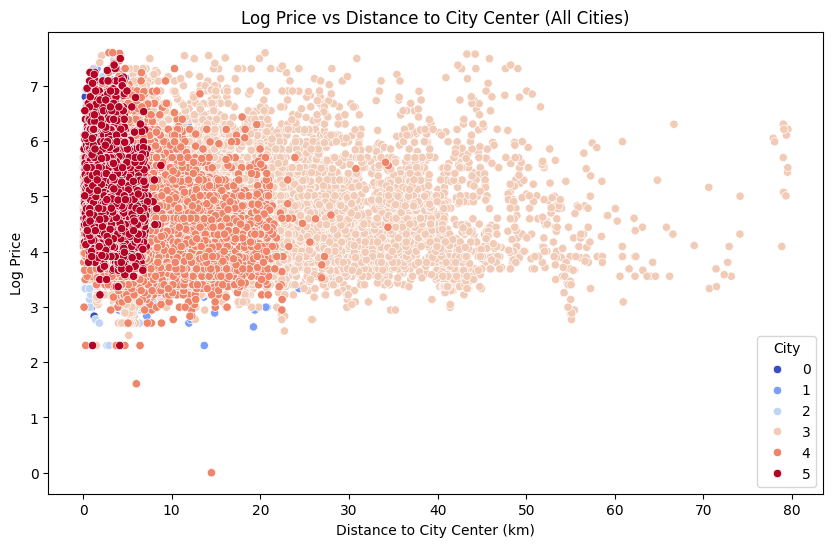

In [ ]:
# Scatter plot: Combined view of all cities
plt.figure(figsize=(10,6))

# Plot all cities together
sns.scatterplot(data=clustered_data, x='distance_to_center', y='log_price', hue='city_encoded', palette='coolwarm')
plt.title('Log Price vs Distance to City Center (All Cities)')
plt.xlabel('Distance to City Center (km)')
plt.ylabel('Log Price')
plt.legend(title='City')
plt.show()


In [ ]:
scaled_transformed_df

In [ ]:
# Splitting data and training model as before
X_train, X_temp, y_train, y_temp = train_test_split(scaled_transformed_df, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.67, random_state=42)

# Train the model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Evaluate the model
y_val_pred = rf.predict(X_val)
val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
val_r2 = r2_score(y_val, y_val_pred)

print(f"Validation RMSE: {val_rmse:.4f}")
print(f"Validation R2: {val_r2:.4f}")

Validation RMSE: 0.3464
Validation R2: 0.7380


**LGBM**

In [ ]:
import lightgbm as lgb


def clean_column_name(name):
    return re.sub(r'\W+', '_', name)


X_train, X_temp, y_train, y_temp = train_test_split(scaled_transformed_df, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.67, random_state=42)

# Fix column names to remove any special characters
X_train = X_train.rename(columns=clean_column_name)
X_val = X_val.rename(columns=clean_column_name)
X_test = X_test.rename(columns=clean_column_name)

# Convert all columns to numeric if applicable
X_train = X_train.apply(pd.to_numeric, errors='ignore')
X_val = X_val.apply(pd.to_numeric, errors='ignore')
X_test = X_test.apply(pd.to_numeric, errors='ignore')

# Ensure consistency in column names
common_columns = X_train.columns.intersection(X_val.columns).intersection(X_test.columns)
X_train = X_train[common_columns]
X_val = X_val[common_columns]
X_test = X_test[common_columns]

# Train the model
lgb_model = lgb.LGBMRegressor(n_estimators=100, random_state=42)
lgb_model.fit(X_train, y_train)

# Evaluate the model on the validation set
y_val_pred = lgb_model.predict(X_val)
val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
val_r2 = r2_score(y_val, y_val_pred)

print(f"Validation RMSE (LightGBM): {val_rmse:.4f}")
print(f"Validation R2 (LightGBM): {val_r2:.4f}")



[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011534 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3573
[LightGBM] [Info] Number of data points in the train set: 40692, number of used features: 42
[LightGBM] [Info] Start training from score 4.749102
Validation RMSE (LightGBM): 0.3347
Validation R2 (LightGBM): 0.7554


In [ ]:
def clean_column_name(name):
    return re.sub(r'\W+', '_', name)

X_train, X_temp, y_train, y_temp = train_test_split(scaled_transformed_df, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.67, random_state=42)

# Fix column names to remove any special characters
X_train = X_train.rename(columns=clean_column_name)
X_val = X_val.rename(columns=clean_column_name)
X_test = X_test.rename(columns=clean_column_name)

# Convert all columns to numeric if applicable
X_train = X_train.apply(pd.to_numeric, errors='ignore')
X_val = X_val.apply(pd.to_numeric, errors='ignore')
X_test = X_test.apply(pd.to_numeric, errors='ignore')

# Ensure consistency in column names
common_columns = X_train.columns.intersection(X_val.columns).intersection(X_test.columns)
X_train = X_train[common_columns]
X_val = X_val[common_columns]
X_test = X_test[common_columns]

def objective(trial: Trial):
    params = {
        "objective": "regression",
        "metric": "rmse",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "n_estimators": trial.suggest_int("n_estimators", 50, 1000),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 1, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 20, 100),
        "max_depth": trial.suggest_int("max_depth", 3, 15),
        "min_child_samples": trial.suggest_int("min_child_samples", 10, 100),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0, 10),
        "reg_lambda": trial.suggest_float("reg_lambda", 0, 10),
    }

    model = lgb.LGBMRegressor(**params)
    score = cross_val_score(model, X_train, y_train, n_jobs=-1, cv=5, scoring="r2")
    return np.mean(score)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.values[0]))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

# Train the model with best hyperparameters
best_params = study.best_params
lgb_model = lgb.LGBMRegressor(**best_params)
lgb_model.fit(X_train, y_train)

# Evaluate the model on the validation set
y_val_pred = lgb_model.predict(X_val)
val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
val_r2 = r2_score(y_val, y_val_pred)

print(f"Validation RMSE (LightGBM with hyperparameter tuning): {val_rmse:.4f}")
print(f"Validation R2 (LightGBM with hyperparameter tuning): {val_r2:.4f}")


[I 2024-09-10 16:40:46,353] A new study created in memory with name: no-name-c4ea113e-f46c-4fdb-9893-d3be00b39ed8
[I 2024-09-10 16:42:10,037] Trial 0 finished with value: 0.5852267392082461 and parameters: {'n_estimators': 808, 'learning_rate': 0.00123820374684396, 'num_leaves': 91, 'max_depth': 13, 'min_child_samples': 46, 'subsample': 0.7732805723670797, 'colsample_bytree': 0.938912080485131, 'reg_alpha': 5.930936263155448, 'reg_lambda': 7.054157717545842}. Best is trial 0 with value: 0.5852267392082461.
[I 2024-09-10 16:42:36,461] Trial 1 finished with value: 0.7507822854695955 and parameters: {'n_estimators': 920, 'learning_rate': 0.508482358552748, 'num_leaves': 32, 'max_depth': 3, 'min_child_samples': 53, 'subsample': 0.5123236033681156, 'colsample_bytree': 0.9565124253989772, 'reg_alpha': 5.033074321595925, 'reg_lambda': 6.578194889207463}. Best is trial 1 with value: 0.7507822854695955.
[I 2024-09-10 16:42:47,326] Trial 2 finished with value: 0.7409599709694688 and parameters: 

Number of finished trials: 20
Best trial:
  Value: 0.7613537609435177
  Params: 
    n_estimators: 534
    learning_rate: 0.07027274980711305
    num_leaves: 50
    max_depth: 11
    min_child_samples: 20
    subsample: 0.6045498801621052
    colsample_bytree: 0.6380103152092059
    reg_alpha: 3.944084467900689
    reg_lambda: 5.492974445064289
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022428 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3573
[LightGBM] [Info] Number of data points in the train set: 40692, number of used features: 42
[LightGBM] [Info] Start training from score 4.749102
Validation RMSE (LightGBM with hyperparameter tuning): 0.3255
Validation R2 (LightGBM with hyperparameter tuning): 0.7687


In [ ]:
y_test_pred = lgb_model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_r2 = r2_score(y_test, y_test_pred)
print(f"Test RMSE (LightGBM with hyperparameter tuning): {test_rmse:.4f}")
print(f"Test R2 (LightGBM with hyperparameter tuning): {test_r2:.4f}")


Test RMSE (LightGBM with hyperparameter tuning): 0.3291
Test R2 (LightGBM with hyperparameter tuning): 0.7601


**XGBoost**

In [ ]:
import xgboost as xgb

# Splitting data and training model as before
X_train, X_temp, y_train, y_temp = train_test_split(scaled_transformed_df, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.67, random_state=42)

# Train the XGBoost model
xgb_model = xgb.XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)

# Evaluate the model
y_val_pred = xgb_model.predict(X_val)
val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
val_r2 = r2_score(y_val, y_val_pred)

print(f"Validation RMSE: {val_rmse:.4f}")
print(f"Validation R2: {val_r2:.4f}")

In [ ]:
from sklearn.model_selection import cross_val_score

def objective(trial: Trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 1000),
        "max_depth": trial.suggest_int("max_depth", 3, 15),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 1, log=True),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 10),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "reg_alpha": trial.suggest_float("reg_alpha", 0, 10),
        "reg_lambda": trial.suggest_float("reg_lambda", 0, 10),
    }

    model = xgb.XGBRegressor(**params)
    score = cross_val_score(model, X_train, y_train, n_jobs=-1, cv=5, scoring="r2")
    return np.mean(score)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.values[0]))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

# Train the model with best hyperparameters
best_params = study.best_params
xgb_model = xgb.XGBRegressor(**best_params)
xgb_model.fit(X_train, y_train)

# Evaluate the model on the validation set
y_val_pred = xgb_model.predict(X_val)
val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
val_r2 = r2_score(y_val, y_val_pred)

print(f"Validation RMSE (XGBoost with hyperparameter tuning): {val_rmse:.4f}")
print(f"Validation R2 (XGBoost with hyperparameter tuning): {val_r2:.4f}")


[I 2024-09-10 16:52:37,597] A new study created in memory with name: no-name-accb6879-1ca3-4eba-b614-b48ed995b75c
[I 2024-09-10 16:53:02,427] Trial 0 finished with value: 0.6065448970813212 and parameters: {'n_estimators': 373, 'max_depth': 6, 'learning_rate': 0.003576257062182492, 'subsample': 0.7700751201251677, 'colsample_bytree': 0.6660025409803875, 'gamma': 4.3565477971664, 'min_child_weight': 10, 'reg_alpha': 5.852271899226541, 'reg_lambda': 5.035064272896256}. Best is trial 0 with value: 0.6065448970813212.
[I 2024-09-10 16:53:09,452] Trial 1 finished with value: 0.71233025971021 and parameters: {'n_estimators': 485, 'max_depth': 4, 'learning_rate': 0.05589109407550469, 'subsample': 0.9230270666594276, 'colsample_bytree': 0.6318883948555825, 'gamma': 6.16623413593839, 'min_child_weight': 7, 'reg_alpha': 3.0893022350646513, 'reg_lambda': 4.02818022239528}. Best is trial 1 with value: 0.71233025971021.
[I 2024-09-10 16:54:18,556] Trial 2 finished with value: 0.7196189278154673 and

Number of finished trials: 20
Best trial:
  Value: 0.7503870183216973
  Params: 
    n_estimators: 985
    max_depth: 10
    learning_rate: 0.19860792181667644
    subsample: 0.6764349296761979
    colsample_bytree: 0.5099816161777956
    gamma: 0.22371937211892146
    min_child_weight: 8
    reg_alpha: 6.539775301131382
    reg_lambda: 2.5242944422042113
Validation RMSE (XGBoost with hyperparameter tuning): 0.3319
Validation R2 (XGBoost with hyperparameter tuning): 0.7595


In [ ]:
best_params

{'n_estimators': 985,
 'max_depth': 10,
 'learning_rate': 0.19860792181667644,
 'subsample': 0.6764349296761979,
 'colsample_bytree': 0.5099816161777956,
 'gamma': 0.22371937211892146,
 'min_child_weight': 8,
 'reg_alpha': 6.539775301131382,
 'reg_lambda': 2.5242944422042113}

In [ ]:
y_test_pred = xgb_model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_r2 = r2_score(y_test, y_test_pred)
print(f"Test RMSE (XGB with hyperparameter tuning): {test_rmse:.4f}")
print(f"Test R2 (XGB with hyperparameter tuning): {test_r2:.4f}")

Test RMSE (XGB with hyperparameter tuning): 0.3368
Test R2 (XGB with hyperparameter tuning): 0.7488


In [ ]:
best_trial = study.best_trial
print('Best trial:')
print(f'  Value: {best_trial.value}')
print(f'  Params: {best_trial.params}')

In [ ]:
lgb_model

# **Stacking (Hierarchical Ensembles)**


In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
def clean_column_name(name):
    return re.sub(r'\W+', '_', name)
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = X_train.rename(columns=clean_column_name)
X_val = X_val.rename(columns=clean_column_name)
X_test = X_test.rename(columns=clean_column_name)

# Convert all columns to numeric if applicable
X_train = X_train.apply(pd.to_numeric, errors='ignore')
X_val = X_val.apply(pd.to_numeric, errors='ignore')
X_test = X_test.apply(pd.to_numeric, errors='ignore')

# Ensure consistency in column names
common_columns = X_train.columns.intersection(X_val.columns).intersection(X_test.columns)
X_train = X_train[common_columns]
X_val = X_val[common_columns]
X_test = X_test[common_columns]


# Create KFold cross-validator
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize base models
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
xgb_model = XGBRegressor(**best_params)
lgb_model = lgb.LGBMRegressor(colsample_bytree=0.6380103152092059,
              learning_rate=0.07027274980711305, max_depth=11, n_estimators=534,
              num_leaves=50, reg_alpha=3.944084467900689,
              reg_lambda=5.492974445064289, subsample=0.6045498801621052)


# Initialize arrays to hold predictions
train_preds_rf = np.zeros((X_train.shape[0],))
test_preds_rf = np.zeros((X_test.shape[0],))

train_preds_xgb = np.zeros((X_train.shape[0],))
test_preds_xgb = np.zeros((X_test.shape[0],))

train_preds_ada = np.zeros((X_train.shape[0],))
test_preds_ada = np.zeros((X_test.shape[0],))

# Stacking using cross-validation
for train_idx, val_idx in kf.split(X_train):
    X_train_cv, X_val_cv = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_train_cv, y_val_cv = y_train.iloc[train_idx], y_train.iloc[val_idx]

    # Random Forest
    rf_model.fit(X_train_cv, y_train_cv)
    train_preds_rf[val_idx] = rf_model.predict(X_val_cv)
    test_preds_rf += rf_model.predict(X_test) / kf.n_splits  # Averaging test predictions

    # XGBoost
    xgb_model.fit(X_train_cv, y_train_cv)
    train_preds_xgb[val_idx] = xgb_model.predict(X_val_cv)
    test_preds_xgb += xgb_model.predict(X_test) / kf.n_splits

    # AdaBoost
    lgb_model.fit(X_train_cv, y_train_cv)
    train_preds_ada[val_idx] = lgb_model.predict(X_val_cv)
    test_preds_ada += lgb_model.predict(X_test) / kf.n_splits

# Combine base model predictions as new features
train_stack = np.column_stack([train_preds_rf, train_preds_xgb, train_preds_ada])
test_stack = np.column_stack([test_preds_rf, test_preds_xgb, test_preds_ada])

# Train the meta-model
meta_model = XGBRegressor(n_estimators=100, random_state=42)
meta_model.fit(train_stack, y_train)

# Make final predictions
final_preds = meta_model.predict(test_stack)

# Evaluate the final predictions
rmse = np.sqrt(mean_squared_error(y_test, final_preds))
r2_score = meta_model.score(test_stack, y_test)
print(f"Stacking Model RMSE: {rmse:.4f}")
print(f"Stacking Model R2 Score: {r2_score:.4f}")

In [ ]:
# Train the meta-model
meta_model = XGBRegressor(**best_params)
meta_model.fit(train_stack, y_train)

# Make final predictions
final_preds = meta_model.predict(test_stack)

# Evaluate the final predictions
rmse = np.sqrt(mean_squared_error(y_test, final_preds))
r2_score = meta_model.score(test_stack, y_test)
print(f"Stacking Model RMSE: {rmse:.4f}")
print(f"Stacking Model R2 Score: {r2_score:.4f}")

Stacking Model RMSE: 0.3195
Stacking Model R2 Score: 0.7708


# **Random Forest Feature Selection + XGBoost Fine-Tuning**

In [ ]:

from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 1: Feature selection using RandomForest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Select the most important features
selector = SelectFromModel(rf_model, threshold='median')
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)

# Step 2: Train XGBoost on selected features
xgb_model = XGBRegressor(**best_params_xg)
xgb_model.fit(X_train_selected, y_train)

# Evaluate on the test set
final_preds = xgb_model.predict(X_test_selected)
rmse = np.sqrt(mean_squared_error(y_test, final_preds))
print(f"RMSE after Feature Selection + XGBoost: {rmse:.4f}")

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


RMSE after Feature Selection + XGBoost: 0.3288


In [ ]:
# Check the number of selected features
num_selected_features = X_train_selected.shape[1]
print(f"Number of features selected: {num_selected_features}")

Number of features selected: 21


In [ ]:
r2_score = xgb_model.score(X_test_selected, y_test)
print(f"R2 Score after Feature Selection + XGBoost: {r2_score:.4f}")

R2 Score after Feature Selection + XGBoost: 0.7572


# **Hybrid Voting Ensemble with Confidence Calibration Method**

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np


def clean_column_name(name):
    return re.sub(r'\W+', '_', name)
# Train-test split

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

X_train = X_train.rename(columns=clean_column_name)
X_val = X_val.rename(columns=clean_column_name)
X_test = X_test.rename(columns=clean_column_name)

# Convert all columns to numeric if applicable
X_train = X_train.apply(pd.to_numeric, errors='ignore')
X_val = X_val.apply(pd.to_numeric, errors='ignore')
X_test = X_test.apply(pd.to_numeric, errors='ignore')

# Ensure consistency in column names
common_columns = X_train.columns.intersection(X_val.columns).intersection(X_test.columns)
X_train = X_train[common_columns]
X_val = X_val[common_columns]
X_test = X_test[common_columns]

# Train-test split


# Train each model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, oob_score=True)
xgb_model = XGBRegressor(**best_params_xg)
lgbm_model = LGBMRegressor(colsample_bytree=0.6380103152092059,
              learning_rate=0.07027274980711305, max_depth=11, n_estimators=534,
              num_leaves=50, reg_alpha=3.944084467900689,
              reg_lambda=5.492974445064289, subsample=0.6045498801621052)

rf_model.fit(X_train, y_train)
xgb_model.fit(X_train, y_train)
lgbm_model.fit(X_train, y_train)

# Get predictions for validation set
rf_val_preds = rf_model.predict(X_val)
xgb_val_preds = xgb_model.predict(X_val)
lgbm_val_preds = lgbm_model.predict(X_val)

# Get confidence scores (standard deviation of predictions from individual trees for RandomForest on validation set)
rf_tree_val_preds = np.array([tree.predict(X_val) for tree in rf_model.estimators_])
rf_val_confidence = np.std(rf_tree_val_preds, axis=0)  # Lower std = higher confidence

# For XGBoost and LightGBM, we assume equal confidence for simplicity
xgb_val_confidence = np.ones_like(rf_val_confidence)  # Placeholder, can be adjusted
lgbm_val_confidence = np.ones_like(rf_val_confidence)  # Placeholder, can be adjusted

# Normalize confidence scores on validation set
total_val_confidence = rf_val_confidence + xgb_val_confidence + lgbm_val_confidence
rf_val_weight = rf_val_confidence / total_val_confidence
xgb_val_weight = xgb_val_confidence / total_val_confidence
lgbm_val_weight = lgbm_val_confidence / total_val_confidence

# Blend predictions using confidence weights on validation set
blended_val_preds = (rf_val_weight * rf_val_preds) + (xgb_val_weight * xgb_val_preds) + (lgbm_val_weight * lgbm_val_preds)

# Evaluate the ensemble model on the validation set
val_rmse = np.sqrt(mean_squared_error(y_val, blended_val_preds))
val_r2 = r2_score(y_val, blended_val_preds)

print(f"Validation RMSE: {val_rmse:.4f}")
print(f"Validation R²: {val_r2:.4f}")

# After validating, let's apply the same approach on the test set

# Get predictions for test set
rf_test_preds = rf_model.predict(X_test)
xgb_test_preds = xgb_model.predict(X_test)
lgbm_test_preds = lgbm_model.predict(X_test)

# Get confidence scores (standard deviation of predictions from individual trees for RandomForest on test set)
rf_tree_test_preds = np.array([tree.predict(X_test) for tree in rf_model.estimators_])
rf_test_confidence = np.std(rf_tree_test_preds, axis=0)  # Lower std = higher confidence

# For XGBoost and LightGBM, we assume equal confidence for simplicity
xgb_test_confidence = np.ones_like(rf_test_confidence)  # Placeholder, can be adjusted
lgbm_test_confidence = np.ones_like(rf_test_confidence)  # Placeholder, can be adjusted

# Normalize confidence scores on test set
total_test_confidence = rf_test_confidence + xgb_test_confidence + lgbm_test_confidence
rf_test_weight = rf_test_confidence / total_test_confidence
xgb_test_weight = xgb_test_confidence / total_test_confidence
lgbm_test_weight = lgbm_test_confidence / total_test_confidence

# Blend predictions using confidence weights on test set
blended_test_preds = (rf_test_weight * rf_test_preds) + (xgb_test_weight * xgb_test_preds) + (lgbm_test_weight * lgbm_test_preds)

# Evaluate the ensemble model on the test set
test_rmse = np.sqrt(mean_squared_error(y_test, blended_test_preds))
test_r2 = r2_score(y_test, blended_test_preds)

print(f"Test RMSE: {test_rmse:.4f}")
print(f"Test R²: {test_r2:.4f}")